In [3]:
from sklearn.datasets import load_diabetes
from sklearn.model_selection import cross_val_score
import pandas as pd
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


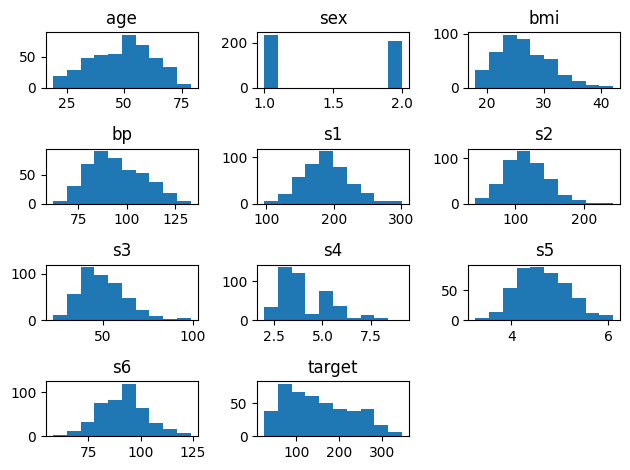

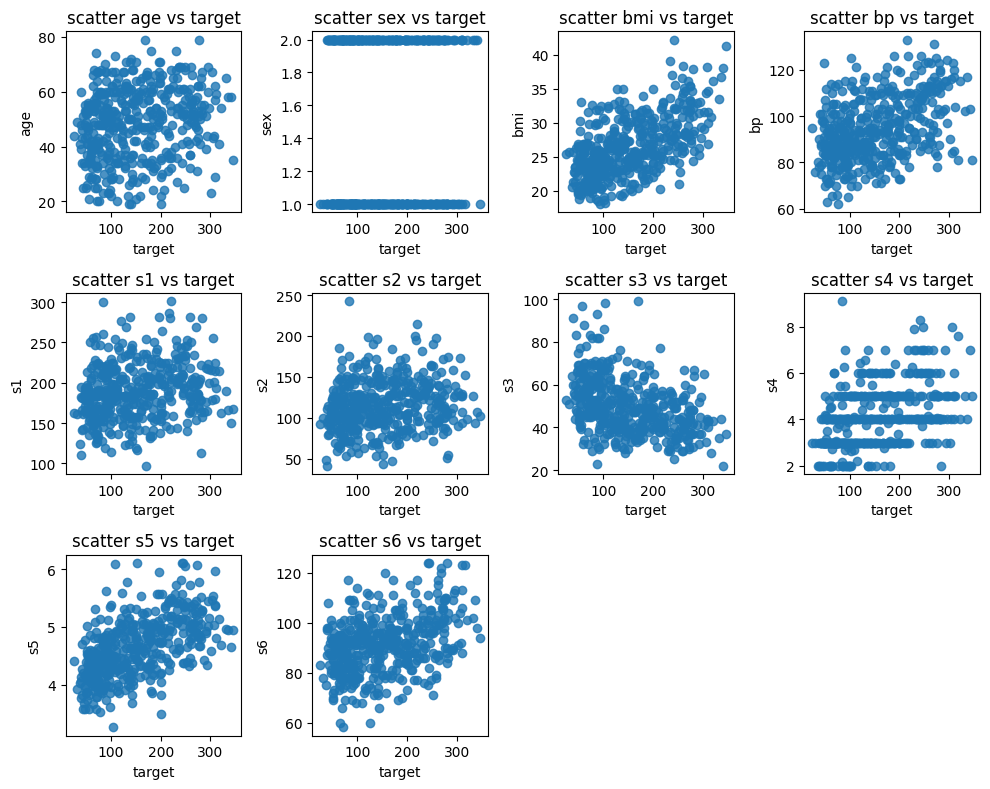

In [48]:
diabetes= load_diabetes(scaled=False)
X = diabetes.data    # Feature
y = diabetes.target  # Target

df = pd.DataFrame(X, columns= diabetes.feature_names)
df['target'] = y

df.hist(grid=False)
plt.tight_layout()

plt.show()

fig, axes = plt.subplots(3,4, figsize=(10,8))

axes = axes.flatten()

for i,col in enumerate(df.columns):
    
    if col != 'target':
        
        axes[i].scatter(y=df[col], x=df['target'], alpha=0.8)
        
        axes[i].set_title(f'scatter {col} vs target')
        axes[i].set_ylabel(col)
        axes[i].set_xlabel('target')
        plt.tight_layout()
    axes[10].set_visible(False)
    axes[11].set_visible(False)
        
plt.show()

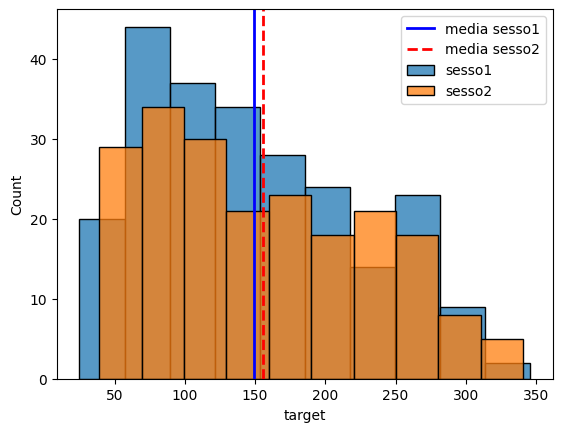

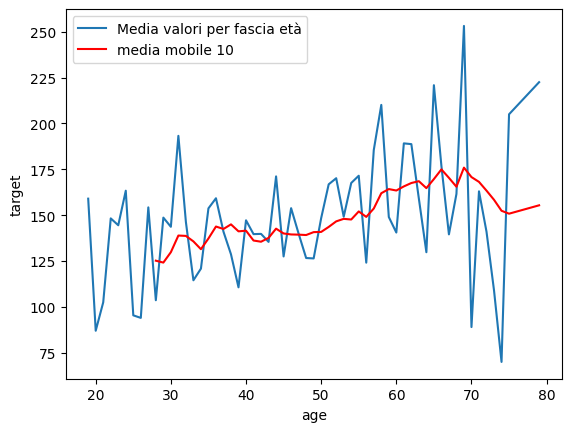

In [5]:
# ANALISI GRAFICA VALORE TARGET CON FEATURES


# Visualizzazione grafica relazione sesso e target
sesso1= df.loc[df['sex']==1]
sesso2 = df.loc[df['sex']==2]

sns.histplot(sesso1['target'],bins=10, label='sesso1' )
sns.histplot(sesso2['target'],bins=10, label='sesso2')
plt.axvline(sesso1['target'].mean(), color='blue', linestyle='-', linewidth=2, label='media sesso1')
plt.axvline(sesso2['target'].mean(), color='red', linestyle='--', linewidth=2, label='media sesso2')
plt.legend()

plt.show()

'''sesso2 ha più osservazioni (235) con valori concentrati a destra , quindi una media inferiore rispetto sesso1;
 sesso1 (207 osservazioni) ha una distibuzione piu piatta e una media piu alta di sesso2;'''
 

# Visualizzazione grafica rapporto tra età e target

mean_for_ages= df.groupby('age')['target'].mean()
mean_df = mean_for_ages.reset_index()
sns.lineplot(x=mean_df['age'], y= mean_df['target'], label="Media valori per fascia età")
sns.lineplot(x=mean_df['age'], y= mean_df['target'].rolling(window=10).mean(), color='red', label="media mobile 10")

"""La correlazione è bassa tra età e target
come si vedrà seguito a causa dell elevata varianza
però è interessante notare che nella fascia centrale sembra esserci
un notevole aumento di soggetti in stadio avanzato in relazione all'età che si potrebbe approfondire"""

plt.show()


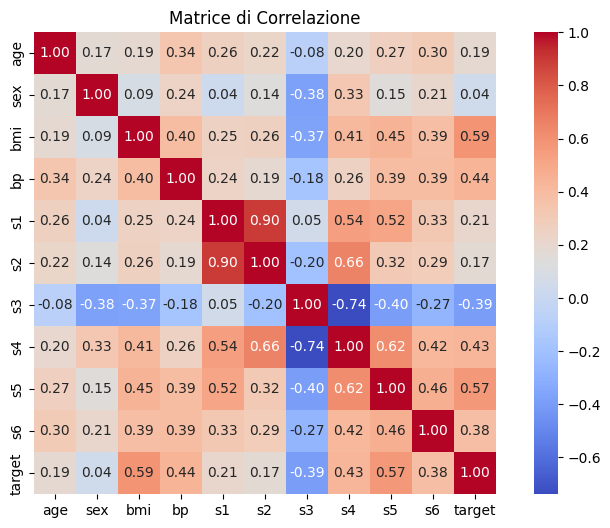

Correlazioni ordinate con il target:
bmi    0.586450
s5     0.565883
bp     0.441482
s4     0.430453
s6     0.382483
s1     0.212022
age    0.187889
s2     0.174054
sex    0.043062
s3    -0.394789
Name: target, dtype: float64


In [6]:
import seaborn as sns
import matplotlib.pyplot as plt

correlation_matrix= df.corr()

# Heatmap della matrice di correlazione
plt.figure(figsize=(10, 6))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True)

plt.title('Matrice di Correlazione')
plt.show()


target_correlation = correlation_matrix['target'].drop('target')
sorted_correlations = target_correlation.sort_values(ascending=False)

# Stampare i nomi delle feature e le loro correlazioni
print("Correlazioni ordinate con il target:")
print(sorted_correlations)

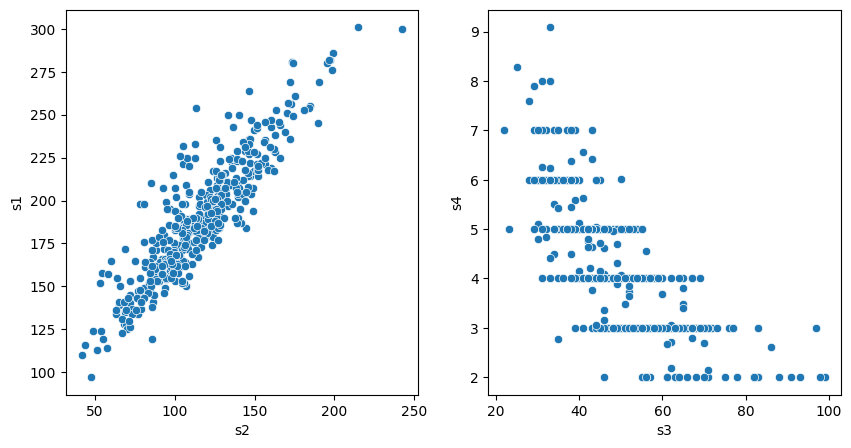

In [54]:
#   Le feature piu informative sono bmi, s5, bp, s4, s6, s3 (inversamente)

# Per problemi di multicollinearità identifichiamo le feature che sono correlate tra di esse
#   S1 e S2 sono correlate al 0.9 
# mentre s4 e s3 lo sono al -0.74 (da un punto di vista grafico s3 sembra piu lineare)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

sns.scatterplot(y=df['s1'], x=df['s2'], ax=ax1)
sns.scatterplot(y=df['s4'], x=df['s3'], ax=ax2)

plt.show()


In [23]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PowerTransformer
from sklearn.compose import ColumnTransformer
# PREPROCESSING

def skew_filter(dataset, threshold=1):

    skewness = dataset.skew(numeric_only=True)
    asymmetric = skewness[(skewness > threshold) | (skewness < -threshold)].index.tolist()
    symmetric = skewness[(skewness <= threshold) & (skewness >= -threshold)].index.tolist()
    return asymmetric, symmetric



In [35]:
lasso = Lasso()
ridge= Ridge()
lr= LinearRegression()
#Aggiungiamo un modello che possa catturare relazioni non linerari e vedere il confronto
rf= RandomForestRegressor()  #(teniamo i valori di iperparametri standard per semplicità)


# Inizializza KFold con 5 fold
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Funzione per effettuare la valutazione cross-section dei modelli
def Evaluate_model(model, X):
    
    r2_list = []
    mse_list = []
    
    
# Cicla attraverso i fold
    for train_index, test_index in kf.split(X):
            
        # Usa gli indici per dividere sia X che y
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y[train_index], y[test_index]  # Applica gli stessi indici a y
        
        #
        asimmetriche = skew_filter(X_train, 0.3)[0]
        
        # Applico simmetrizzazione alle colonne con più skewness e Standardizzazione per ogni fold di train
        pipeline= ColumnTransformer([
            ('Yeo-Johnson', PowerTransformer(), asimmetriche),
            ('StandardScaler', StandardScaler(), X.columns)
        ])
             
        X_train = pipeline.fit_transform(X_train)
        X_test = pipeline.transform(X_test)
        
        # Allena il modello
        model.fit(X_train, y_train)
        
        # Fai previsioni
        y_pred = model.predict(X_test)
        
        # Calcola il MSE e R2
        mse = mean_squared_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)
        mse_list.append(mse)
        r2_list.append(r2)
        
    print(f"Media MSE per {str(model)[:-2]}: {np.array(mse_list).mean()}")
    print(f"Lista R2 nei fold: {r2_list}")
    print(f"Media R2 per {str(model)[:-2]}: {np.array(r2_list).mean()}\n")
    
    

In [69]:
modelli= [lr,lasso,ridge,rf]

# tutte le features escluse quelle correlate ad altre (S3 e S2)
all_features= df[['bmi', 'bp','age','sex','s1','s3','s5','s6']]

# Selezione di feature principali con più correlazione
core_features= df[['bmi', 'bp','s3','s5','s6']]


print(f" VALUTAZIONE MODELLI CON TUTTE LE FEATURES")
for modello in modelli:
    Evaluate_model(modello,all_features)
    
    

 VALUTAZIONE MODELLI CON TUTTE LE FEATURES
MSE mean for LinearRegression: 3021.7346828400855
Lista R2 nei fold: [0.46128035452143423, 0.5555871635344048, 0.38641415141599844, 0.5908953001294606, 0.39350980071856767]
Mean R2 for LinearRegression: 0.47753735406397313

MSE mean for Lasso: 3008.8121241165545
Lista R2 nei fold: [0.45632815074505084, 0.5629422200055045, 0.3926653373611084, 0.586905703005491, 0.4002733082159299]
Mean R2 for Lasso: 0.47982294386661695

MSE mean for Ridge: 3010.7444515703296
Lista R2 nei fold: [0.45706248856529164, 0.5619899003597586, 0.39279789494941564, 0.5875880327795442, 0.39796015259626616]
Mean R2 for Ridge: 0.4794796938500553

MSE mean for RandomForestRegressor: 3426.8453968079675
Lista R2 nei fold: [0.4205354516370854, 0.5019107567290013, 0.22879126349562795, 0.4719357530885724, 0.42639619904902737]
Mean R2 for RandomForestRegressor: 0.40991388479986285



In [70]:
print(f"VALUTAZIONE MODELLI CON LE CORE FEATURES")
for modello in modelli:
    Evaluate_model(modello,core_features)

VALUTAZIONE MODELLI CON LE CORE FEATURES
MSE mean for LinearRegression: 3096.0656934474814
Lista R2 nei fold: [0.4455888277861204, 0.5304293182119566, 0.3493758269155991, 0.6154088498763519, 0.376515515899588]
Mean R2 for LinearRegression: 0.46346366773792325

MSE mean for Lasso: 3114.016582294827
Lista R2 nei fold: [0.4415001205242822, 0.5350000052657979, 0.35462117819815864, 0.5932122571578053, 0.3808526882714478]
Mean R2 for Lasso: 0.46103724988349837

MSE mean for Ridge: 3088.8178421643765
Lista R2 nei fold: [0.44731954741944224, 0.5364632609287983, 0.3521390326599799, 0.6091570437819033, 0.3794619027388261]
Mean R2 for Ridge: 0.4649081575057899

MSE mean for RandomForestRegressor: 3506.2605422957104
Lista R2 nei fold: [0.4012776598232979, 0.5092702360869732, 0.18918153559003825, 0.4816054538890656, 0.392312476829332]
Mean R2 for RandomForestRegressor: 0.39472947244374135



In [74]:
''' I modelli sembrano performare mediamente meglio con tutte le feature anche quelle meno informative.
Non sembranon esserci particolari differenze tra la regressione lineare e i modelli con penalizzazione sui pesi.
Il RandomForest è il peggiore e non sembra riuscire a generalizzare sui dati in modo sostanziale'''

# Proviamo a valutare i modelli Reg Lineare e Random Forest su tutto il dataset escludendo anche qui le feature correlate
ss= StandardScaler()
#applichiamo standardizzazione su tutto il set (solo dimostrativo) per valutare come si adattano i modelli
new_x= ss.fit_transform(all_features)


lr.fit(new_x,y)
lr_pred = lr.predict(new_x)
r2_lr = r2_score(y, lr_pred)
mse_lr= mean_squared_error(y, lr_pred)

rf.fit(new_x,y)
rf_pred = rf.predict(new_x)
r2_rf = r2_score(y, rf_pred)
mse_rf= mean_squared_error(y, rf_pred)


print(f"r2 LinearReg: {r2_lr}, MSE: {mse_lr}")
print(f"r2 RandomForestReg: {r2_rf}, MSE: {mse_rf}")
print("\n")


# Creiamo il modello usando statsmodels per conoscere sia coefficienti che pvalue
import statsmodels.api as sm
X_with_const = sm.add_constant(new_x)

model = sm.OLS(y, X_with_const)
results = model.fit()

pvalue = pd.Series(results.pvalues).apply(lambda x: f'{x:.4f}')
for i,col in enumerate(all_features.columns):
    print(f"Coeff {col}:{results.params[i]}; PValue: {pvalue[i]}")
    

''' Le Feature che hanno un pvalue più basso e hanno una relazione piu forte sono bmi, bp, s6 \
    mentre s5 riusulta stranamente di segno opposto nonostante la corr positiva (comunque non forte 0.57)
    Sex influisce molto poco e ha un pvalue troppo elevato per essere valido\
        Age è stato catturato in maniera positiva, in modo che influisce sui valori target in modo positivo'''



r2 LinearReg: 0.5146020668460152, MSE: 2878.3538728013305
r2 RandomForestReg: 0.9201360174413082, MSE: 473.58422398190044


Coeff bmi:152.133484162896; PValue: 0.0000
Coeff bp:25.039706823573248; PValue: 0.0000
Coeff age:15.076113440068324; PValue: 0.0000
Coeff sex:-0.36258108804577904; PValue: 0.8985
Coeff s1:-11.033522542894746; PValue: 0.0002
Coeff s3:-6.917421111788777; PValue: 0.0344
Coeff s5:-11.169696126895158; PValue: 0.0009
Coeff s6:25.71888122476736; PValue: 0.0000


' Le Feature che hanno un pvalue più basso e hanno una relazione piu forte continuano ad essere bmi, bp, s6'

In [46]:
''' Tutti i modelli migliorano potendo osservare tutto il dataset e
il migliore risulta essere il RandomForestRegressor che però arriva ad un livello di r2 molto più
alto rispetto alla cross-validation indicandoci una maggior inclinazione a overfittare i dati. 
La Regressione Lineare cattura solo il 50% della variabilità, un poco meglio rispetto alla cross validation e mostrando
meno inclinazione all'overfitting in questo dataset'''

f[['bmi', 'bp','s4','s5','s6']]

test_lr= 0.4566631903958216
test_rf= 0.4014596919946971

# Calcoliamo la diff% nell'R2 della cross-val e  R2 su totale dataset, per modello
tt_diff_lr= (r2_lr - test_lr) / r2_lr
tt_diff_rf=  (r2_rf - test_rf) / r2_rf

print(f" Train-test diff RandomForest:{tt_diff_rf}, Train-test diff LinearReg:{tt_diff_lr}  ")

 Train-test diff RandomForest:0.5636126127639082, Train-test diff LinearReg:0.11262459630398225  
